In [1]:
from vectorhash_imported import *
from vectorhash_convered import *
from nd_scaffold import GridScaffold
import math
from scipy.stats import norm


lambdas = [3, 4, 5]
shapes = [(i, i) for i in lambdas]
percent_nonzero_relu = 0.5  #
W_gh_var = 1
sparse_initialization = 0.1
T = 0.1
W_hg_std = math.sqrt(W_gh_var)
W_hg_mean = -W_hg_std * norm.ppf(1 - percent_nonzero_relu) / math.sqrt(len(lambdas))
h_normal_mean = len(lambdas) * W_hg_mean
h_normal_std = math.sqrt(len(lambdas)) * W_hg_std
relu_theta = math.sqrt((1 - sparse_initialization) * len(lambdas)) * norm.ppf(
    1 - percent_nonzero_relu
)
num_imgs = 200

print(
    percent_nonzero_relu, W_hg_mean, W_hg_std, h_normal_mean, h_normal_std, relu_theta
)

GS = GridScaffold(
    shapes=shapes,
    N_h=250,
    input_size=784,
    device=None,
    learned_pseudo="bidirectional",
    hidden_layer_factor=0,
    sparse_matrix_initializer=SparseMatrixBySparsityInitializer(
        sparsity=sparse_initialization, device="cpu"
    ),
    # relu_theta=0,
    # sparse_matrix_initializer=SparseMatrixByScalingInitializer(
    #     scale=W_hg_std, mean=W_hg_mean, device="cpu"
    # ),
    relu_theta=relu_theta,
    T=T,
    # h fix
    calculate_update_scaling_method="n_h",
    use_h_fix=False,  # true if norm scaling, false 25/32, true 21/32 11/32
    h_normal_mean=h_normal_mean,
    h_normal_std=h_normal_std,
    # epsilon=0.01,
    scaling_updates=False,  # only relevant when using hebbian false 21/32, true 15/32 7/32
    sanity_check=False,
    # dream_fix=1,
    # zero_tol=1,
)

0.5 -0.0 1.0 -0.0 1.7320508075688772 0.0
UPDATE SCALING BY SCHWARZ ERROR False
module shapes:  [(3, 3), (4, 4), (5, 5)]
N_g     :  50
N_patts :  3600
N_h     :  250


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/200 [00:00<?, ?it/s]/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/vectorhash/nd_scaffold.py:599: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  1 + input.T @ self.inhibition_matrix_hs @ input
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/vectorhash/nd_scaffold.py:738: UserWarning: Using a target size (torch.Size([1, 250])) that is different to the input size (torch.Size([250])). This w

info for each h directly after learning it
h max, min, mean tensor(4.6313) tensor(0.) tensor(0.7077)
h_from_s max, min, mean tensor(4.6306) tensor(0.) tensor(0.7076)
h_from_s_denoised max, min, mean tensor(4.6336) tensor(0.) tensor(0.7081)
avg nonzero/greaterzero h from book: tensor(141) tensor(141)
avg nonzero/greaterzero h from s: tensor(141) tensor(141)
avg nonzero/greaterzero h from s denoised: tensor(141) tensor(141)
mse/cosinesimilarity h from book and h from s tensor(2.6036e-08) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(8.2945e-07) tensor([1.])
mse/cosinesimilarity s and s from h from s tensor(1218.6587) tensor([1.])
mse/cosinesimilarity s and s from h from s denoised tensor(1215.7526) tensor([1.0000])
mse/cosinesimilarity s and s from h tensor(1218.1780) tensor([1.])
info for each h directly after learning it
h max, min, mean tensor(5.2250) tensor(0.) tensor(0.5790)
h_from_s max, min, mean tensor(5.2241) tensor(0.) tensor(0.5789)
h_from_s_denois

 13%|█▎        | 26/200 [00:00<00:02, 81.54it/s]

info for each h directly after learning it
h max, min, mean tensor(5.1572) tensor(0.) tensor(0.6224)
h_from_s max, min, mean tensor(5.1566) tensor(0.) tensor(0.6224)
h_from_s_denoised max, min, mean tensor(5.1600) tensor(0.) tensor(0.6228)
avg nonzero/greaterzero h from book: tensor(121) tensor(121)
avg nonzero/greaterzero h from s: tensor(245) tensor(245)
avg nonzero/greaterzero h from s denoised: tensor(121) tensor(121)
mse/cosinesimilarity h from book and h from s tensor(5.2020e-08) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(8.0972e-07) tensor([1.0000])
mse/cosinesimilarity s and s from h from s tensor(1473.9861) tensor([0.9565])
mse/cosinesimilarity s and s from h from s denoised tensor(1471.3494) tensor([0.9565])
mse/cosinesimilarity s and s from h tensor(1473.5957) tensor([0.9565])
info for each h directly after learning it
h max, min, mean tensor(4.5043) tensor(0.) tensor(0.7294)
h_from_s max, min, mean tensor(4.5031) tensor(0.) tensor(0.7293)
h_f

 26%|██▌       | 51/200 [00:00<00:01, 102.89it/s]

info for each h directly after learning it
h max, min, mean tensor(5.3894) tensor(0.) tensor(0.6442)
h_from_s max, min, mean tensor(5.3867) tensor(0.) tensor(0.6444)
h_from_s_denoised max, min, mean tensor(5.3932) tensor(0.) tensor(0.6447)
avg nonzero/greaterzero h from book: tensor(119) tensor(119)
avg nonzero/greaterzero h from s: tensor(213) tensor(213)
avg nonzero/greaterzero h from s denoised: tensor(119) tensor(119)
mse/cosinesimilarity h from book and h from s tensor(3.3298e-07) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(8.9729e-07) tensor([1.])
mse/cosinesimilarity s and s from h from s tensor(1399.0421) tensor([0.8220])
mse/cosinesimilarity s and s from h from s denoised tensor(1398.5151) tensor([0.8220])
mse/cosinesimilarity s and s from h tensor(1398.9265) tensor([0.8220])
info for each h directly after learning it
h max, min, mean tensor(4.5995) tensor(0.) tensor(0.7205)
h_from_s max, min, mean tensor(4.5983) tensor(0.) tensor(0.7205)
h_f

 38%|███▊      | 77/200 [00:00<00:01, 113.10it/s]

info for each h directly after learning it
h max, min, mean tensor(4.9300) tensor(0.) tensor(0.6969)
h_from_s max, min, mean tensor(4.9288) tensor(0.) tensor(0.6971)
h_from_s_denoised max, min, mean tensor(4.9325) tensor(0.) tensor(0.6974)
avg nonzero/greaterzero h from book: tensor(127) tensor(127)
avg nonzero/greaterzero h from s: tensor(234) tensor(234)
avg nonzero/greaterzero h from s denoised: tensor(127) tensor(127)
mse/cosinesimilarity h from book and h from s tensor(1.4184e-06) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(8.5515e-07) tensor([1.0000])
mse/cosinesimilarity s and s from h from s tensor(1857.8212) tensor([0.7509])
mse/cosinesimilarity s and s from h from s denoised tensor(1857.9927) tensor([0.7509])
mse/cosinesimilarity s and s from h tensor(1857.9078) tensor([0.7509])
info for each h directly after learning it
h max, min, mean tensor(4.9080) tensor(0.) tensor(0.7754)
h_from_s max, min, mean tensor(4.9054) tensor(0.) tensor(0.7754)

 44%|████▍     | 89/200 [00:00<00:01, 109.87it/s]

info for each h directly after learning it
h max, min, mean tensor(4.9179) tensor(0.) tensor(0.6553)
h_from_s max, min, mean tensor(4.9110) tensor(0.) tensor(0.6559)
h_from_s_denoised max, min, mean tensor(4.9200) tensor(0.) tensor(0.6558)
avg nonzero/greaterzero h from book: tensor(126) tensor(126)
avg nonzero/greaterzero h from s: tensor(234) tensor(234)
avg nonzero/greaterzero h from s denoised: tensor(126) tensor(126)
mse/cosinesimilarity h from book and h from s tensor(5.3101e-06) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(7.5557e-07) tensor([1.0000])
mse/cosinesimilarity s and s from h from s tensor(2703.1685) tensor([0.7291])
mse/cosinesimilarity s and s from h from s denoised tensor(2705.9414) tensor([0.7288])
mse/cosinesimilarity s and s from h tensor(2706.0146) tensor([0.7288])
info for each h directly after learning it
h max, min, mean tensor(4.3385) tensor(0.) tensor(0.6102)
h_from_s max, min, mean tensor(4.3319) tensor(0.) tensor(0.6103)

 56%|█████▋    | 113/200 [00:01<00:00, 106.38it/s]

info for each h directly after learning it
h max, min, mean tensor(4.4200) tensor(0.) tensor(0.6615)
h_from_s max, min, mean tensor(4.4171) tensor(0.) tensor(0.6614)
h_from_s_denoised max, min, mean tensor(4.4223) tensor(0.) tensor(0.6620)
avg nonzero/greaterzero h from book: tensor(126) tensor(126)
avg nonzero/greaterzero h from s: tensor(207) tensor(207)
avg nonzero/greaterzero h from s denoised: tensor(126) tensor(126)
mse/cosinesimilarity h from book and h from s tensor(1.6376e-06) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(9.1929e-07) tensor([1.])
mse/cosinesimilarity s and s from h from s tensor(2923.4822) tensor([0.6525])
mse/cosinesimilarity s and s from h from s denoised tensor(2924.7532) tensor([0.6524])
mse/cosinesimilarity s and s from h tensor(2924.2319) tensor([0.6524])
info for each h directly after learning it
h max, min, mean tensor(3.8415) tensor(0.) tensor(0.5961)
h_from_s max, min, mean tensor(3.8383) tensor(0.) tensor(0.5963)
h_f

 62%|██████▏   | 124/200 [00:01<00:00, 95.89it/s] 

info for each h directly after learning it
h max, min, mean tensor(4.2222) tensor(0.) tensor(0.5149)
h_from_s max, min, mean tensor(4.2170) tensor(0.) tensor(0.5151)
h_from_s_denoised max, min, mean tensor(4.2260) tensor(0.) tensor(0.5153)
avg nonzero/greaterzero h from book: tensor(121) tensor(121)
avg nonzero/greaterzero h from s: tensor(206) tensor(206)
avg nonzero/greaterzero h from s denoised: tensor(121) tensor(121)
mse/cosinesimilarity h from book and h from s tensor(3.2064e-06) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(5.7901e-07) tensor([1.0000])
mse/cosinesimilarity s and s from h from s tensor(4984.2007) tensor([0.8390])
mse/cosinesimilarity s and s from h from s denoised tensor(4984.7695) tensor([0.8389])
mse/cosinesimilarity s and s from h tensor(4987.6626) tensor([0.8388])
info for each h directly after learning it
h max, min, mean tensor(4.8376) tensor(0.) tensor(0.6698)
h_from_s max, min, mean tensor(4.8342) tensor(0.) tensor(0.6700)

 72%|███████▏  | 143/200 [00:01<00:00, 83.18it/s]

tensor(4.0384) tensor(0.) tensor(0.6100)
avg nonzero/greaterzero h from book: tensor(123) tensor(123)
avg nonzero/greaterzero h from s: tensor(216) tensor(216)
avg nonzero/greaterzero h from s denoised: tensor(123) tensor(123)
mse/cosinesimilarity h from book and h from s tensor(1.7453e-05) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(6.7349e-07) tensor([1.])
mse/cosinesimilarity s and s from h from s tensor(1790.8986) tensor([0.8030])
mse/cosinesimilarity s and s from h from s denoised tensor(1790.3243) tensor([0.8030])
mse/cosinesimilarity s and s from h tensor(1791.0759) tensor([0.8030])
info for each h directly after learning it
h max, min, mean tensor(4.2899) tensor(0.) tensor(0.6199)
h_from_s max, min, mean tensor(4.2867) tensor(0.) tensor(0.6201)
h_from_s_denoised max, min, mean tensor(4.2940) tensor(0.) tensor(0.6204)
avg nonzero/greaterzero h from book: tensor(124) tensor(124)
avg nonzero/greaterzero h from s: tensor(204) tensor(204)
avg nonze

 80%|████████  | 161/200 [00:01<00:00, 80.24it/s]

tensor(1869.9963) tensor([0.7890])
mse/cosinesimilarity s and s from h tensor(1870.6221) tensor([0.7890])
info for each h directly after learning it
h max, min, mean tensor(5.3645) tensor(0.) tensor(0.7017)
h_from_s max, min, mean tensor(5.3501) tensor(0.) tensor(0.7020)
h_from_s_denoised max, min, mean tensor(5.3679) tensor(0.) tensor(0.7022)
avg nonzero/greaterzero h from book: tensor(128) tensor(128)
avg nonzero/greaterzero h from s: tensor(218) tensor(218)
avg nonzero/greaterzero h from s denoised: tensor(128) tensor(128)
mse/cosinesimilarity h from book and h from s tensor(9.7247e-06) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(9.5841e-07) tensor([1.])
mse/cosinesimilarity s and s from h from s tensor(4273.0381) tensor([0.7676])
mse/cosinesimilarity s and s from h from s denoised tensor(4272.4600) tensor([0.7675])
mse/cosinesimilarity s and s from h tensor(4274.0928) tensor([0.7675])
info for each h directly after learning it
h max, min, mean ten

 90%|████████▉ | 179/200 [00:02<00:00, 79.75it/s]

info for each h directly after learning it
h max, min, mean tensor(4.5780) tensor(0.) tensor(0.6378)
h_from_s max, min, mean tensor(4.5713) tensor(0.) tensor(0.6384)
h_from_s_denoised max, min, mean tensor(4.5813) tensor(0.) tensor(0.6382)
avg nonzero/greaterzero h from book: tensor(127) tensor(127)
avg nonzero/greaterzero h from s: tensor(221) tensor(221)
avg nonzero/greaterzero h from s denoised: tensor(127) tensor(127)
mse/cosinesimilarity h from book and h from s tensor(7.4635e-06) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(7.9814e-07) tensor([1.])
mse/cosinesimilarity s and s from h from s tensor(4987.5879) tensor([0.7669])
mse/cosinesimilarity s and s from h from s denoised tensor(4985.0454) tensor([0.7670])
mse/cosinesimilarity s and s from h tensor(4987.3813) tensor([0.7669])
info for each h directly after learning it
h max, min, mean tensor(4.0409) tensor(0.) tensor(0.6910)
h_from_s max, min, mean tensor(4.0321) tensor(0.) tensor(0.6910)
h_f

 94%|█████████▍| 188/200 [00:02<00:00, 77.20it/s]

info for each h directly after learning it
h max, min, mean tensor(4.8644) tensor(0.) tensor(0.7282)
h_from_s max, min, mean tensor(4.8497) tensor(0.) tensor(0.7277)
h_from_s_denoised max, min, mean tensor(4.8675) tensor(0.) tensor(0.7286)
avg nonzero/greaterzero h from book: tensor(133) tensor(133)
avg nonzero/greaterzero h from s: tensor(212) tensor(212)
avg nonzero/greaterzero h from s denoised: tensor(132) tensor(132)
mse/cosinesimilarity h from book and h from s tensor(2.1715e-05) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(9.4870e-07) tensor([1.0000])
mse/cosinesimilarity s and s from h from s tensor(1055.9952) tensor([0.8793])
mse/cosinesimilarity s and s from h from s denoised tensor(1052.5885) tensor([0.8797])
mse/cosinesimilarity s and s from h tensor(1053.2244) tensor([0.8797])
info for each h directly after learning it
h max, min, mean tensor(3.9888) tensor(0.) tensor(0.5943)
h_from_s max, min, mean tensor(3.9825) tensor(0.) tensor(0.5944)

100%|██████████| 200/200 [00:02<00:00, 86.18it/s]


info for each h directly after learning it
h max, min, mean tensor(4.8610) tensor(0.) tensor(0.6489)
h_from_s max, min, mean tensor(4.8507) tensor(0.) tensor(0.6490)
h_from_s_denoised max, min, mean tensor(4.8655) tensor(0.) tensor(0.6494)
avg nonzero/greaterzero h from book: tensor(118) tensor(118)
avg nonzero/greaterzero h from s: tensor(206) tensor(206)
avg nonzero/greaterzero h from s denoised: tensor(117) tensor(117)
mse/cosinesimilarity h from book and h from s tensor(1.2140e-05) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(9.5381e-07) tensor([1.0000])
mse/cosinesimilarity s and s from h from s tensor(3435.1731) tensor([0.7674])
mse/cosinesimilarity s and s from h from s denoised tensor(3431.4590) tensor([0.7676])
mse/cosinesimilarity s and s from h tensor(3432.8950) tensor([0.7676])
info for each h directly after learning it
h max, min, mean tensor(4.7548) tensor(0.) tensor(0.5662)
h_from_s max, min, mean tensor(4.7363) tensor(0.) tensor(0.5667)

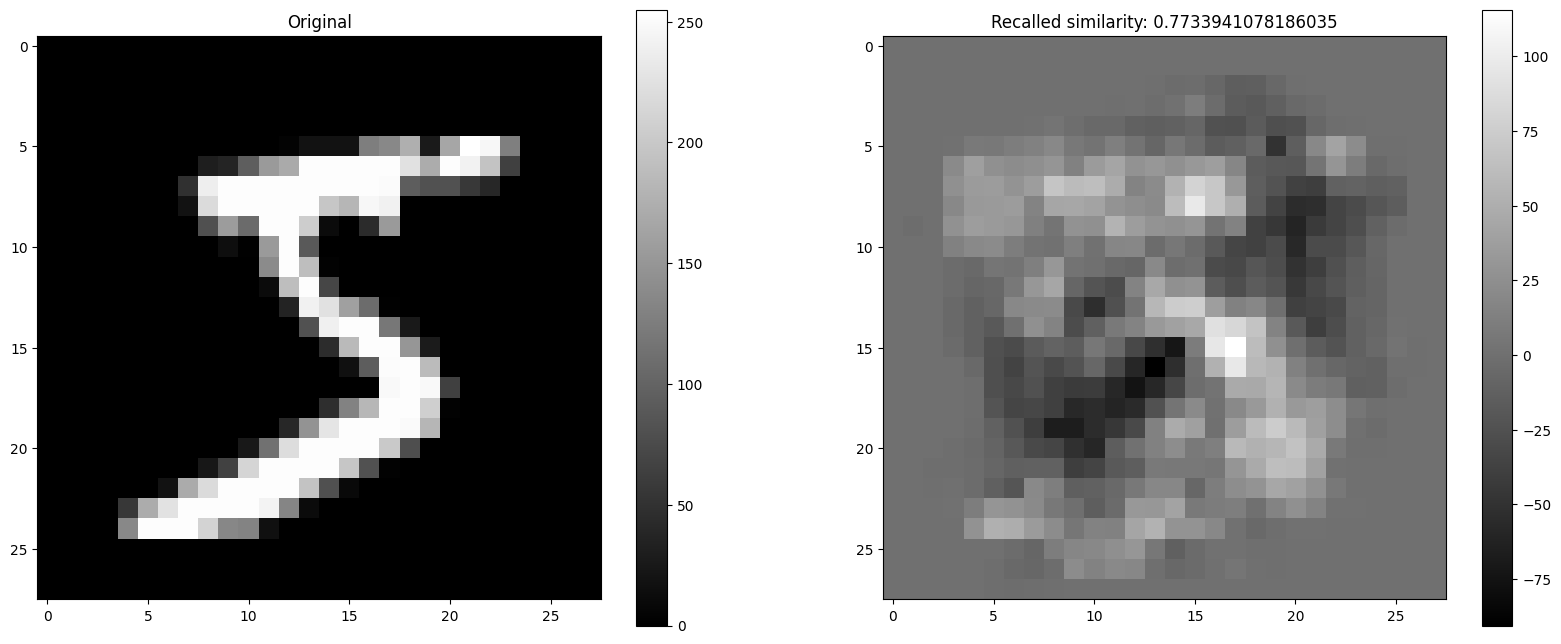

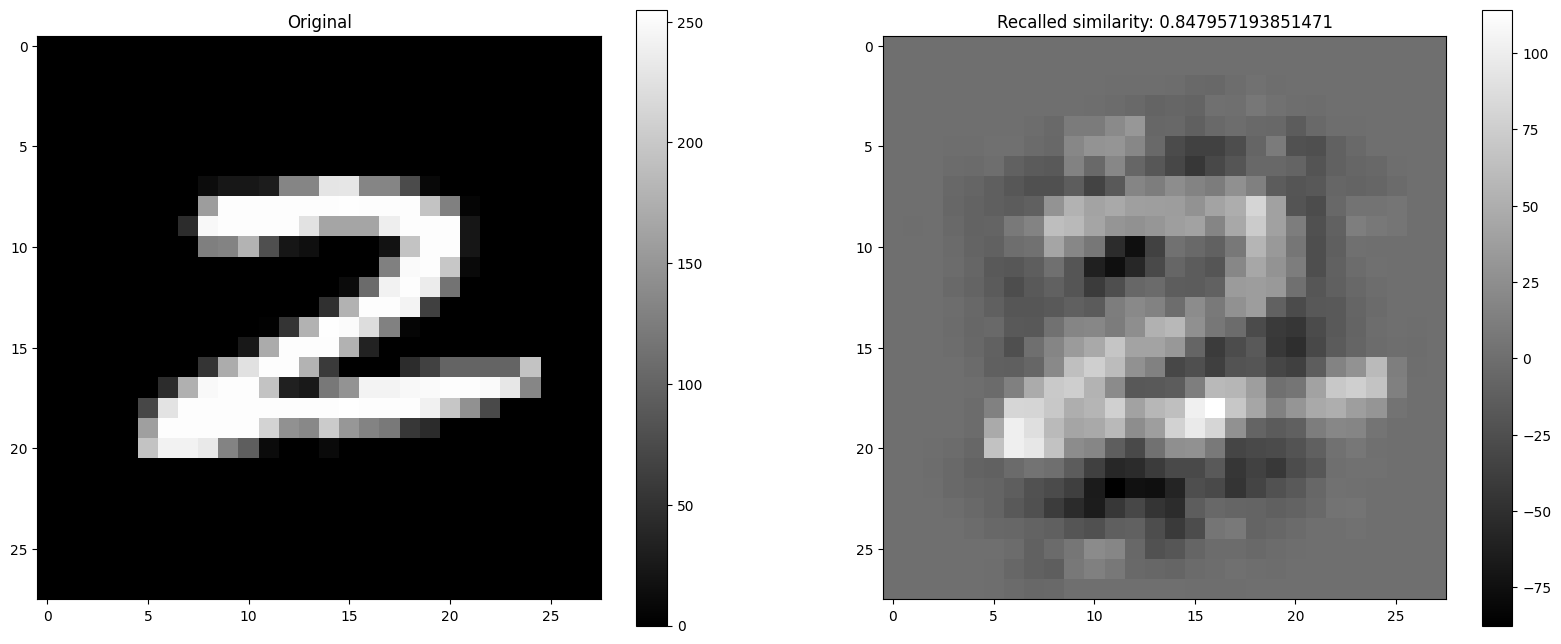

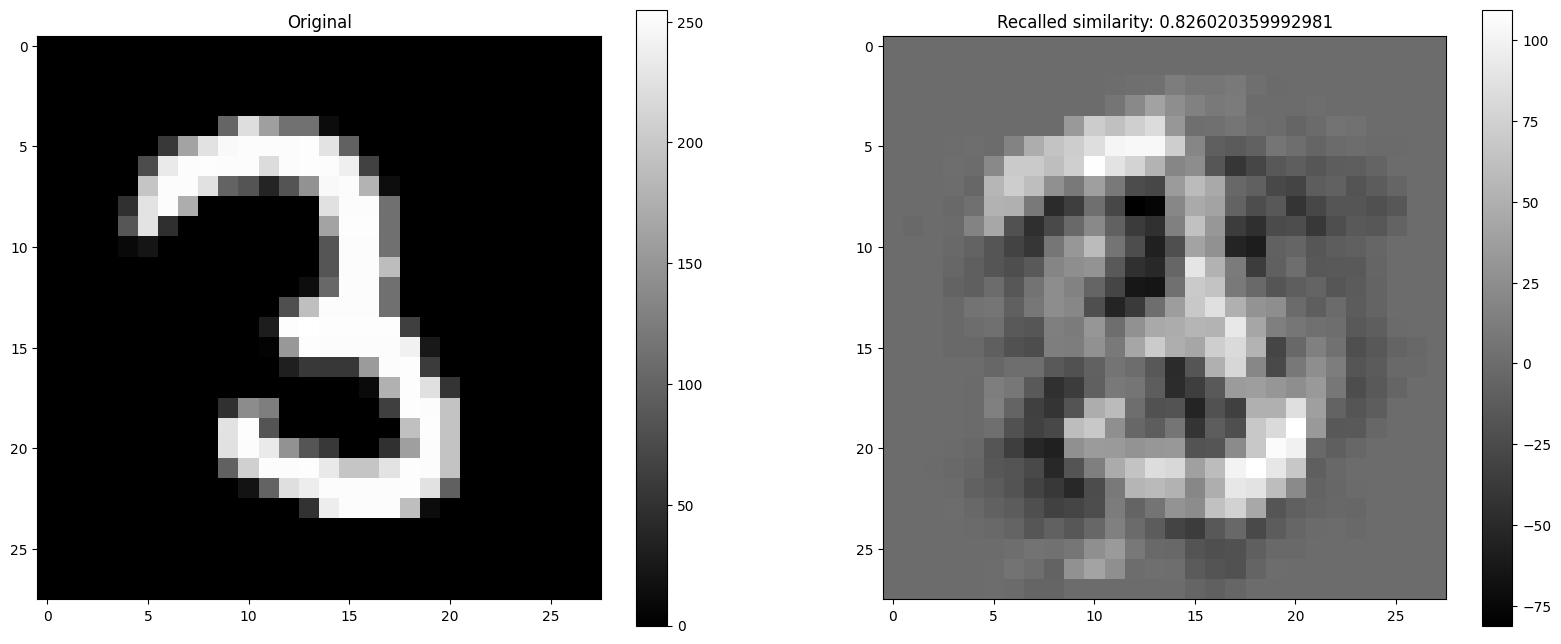

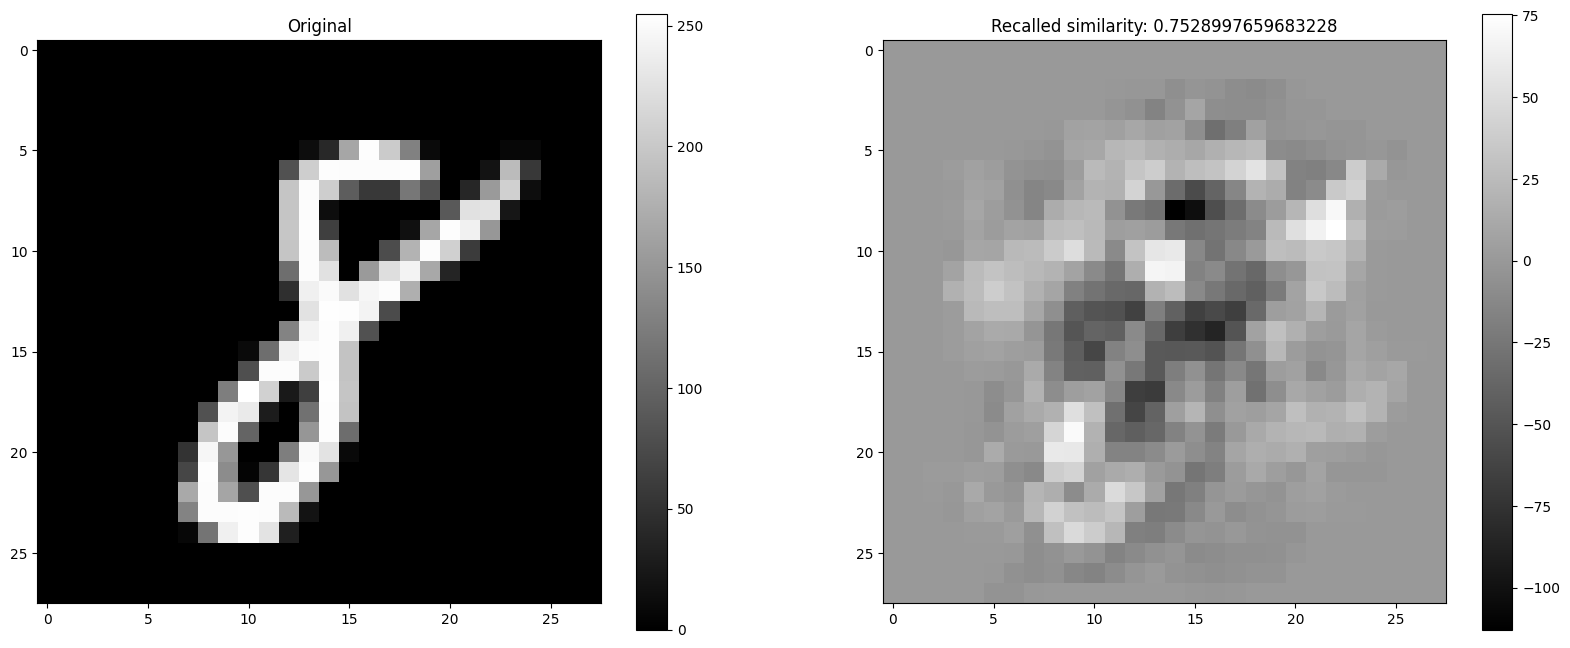

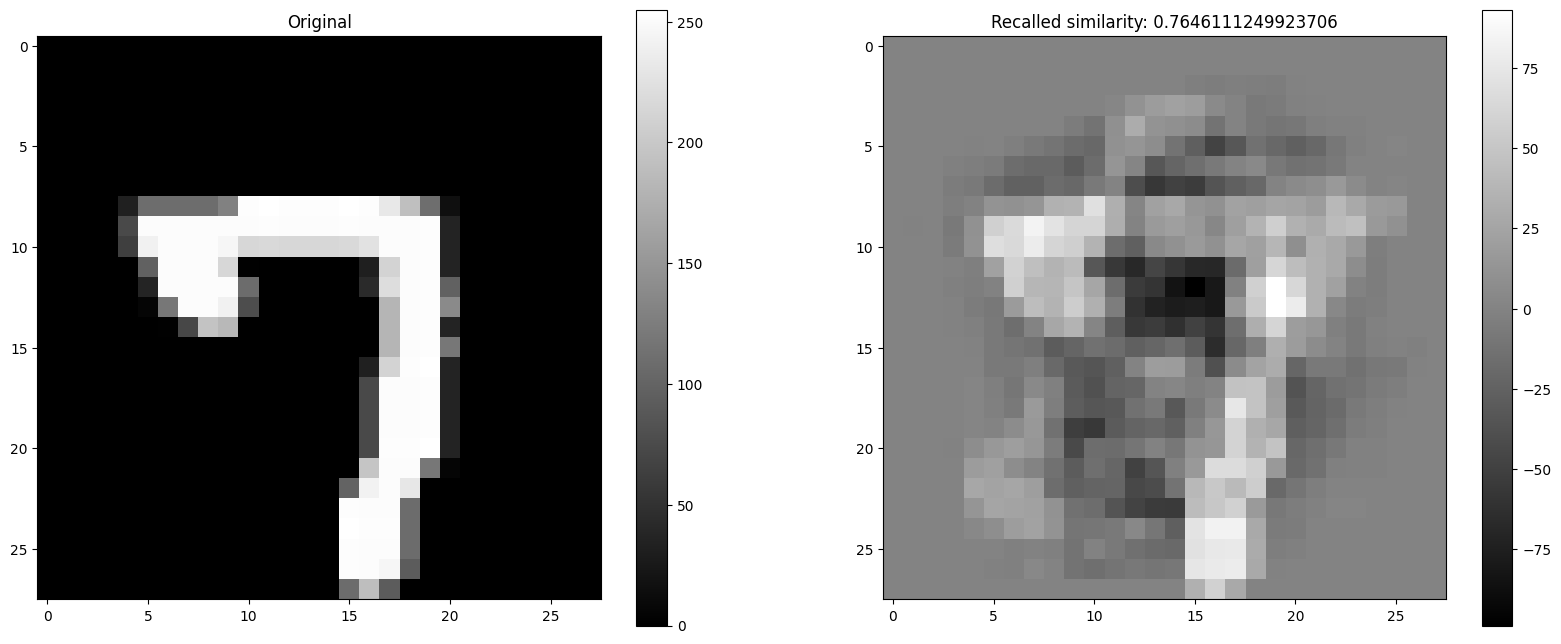

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


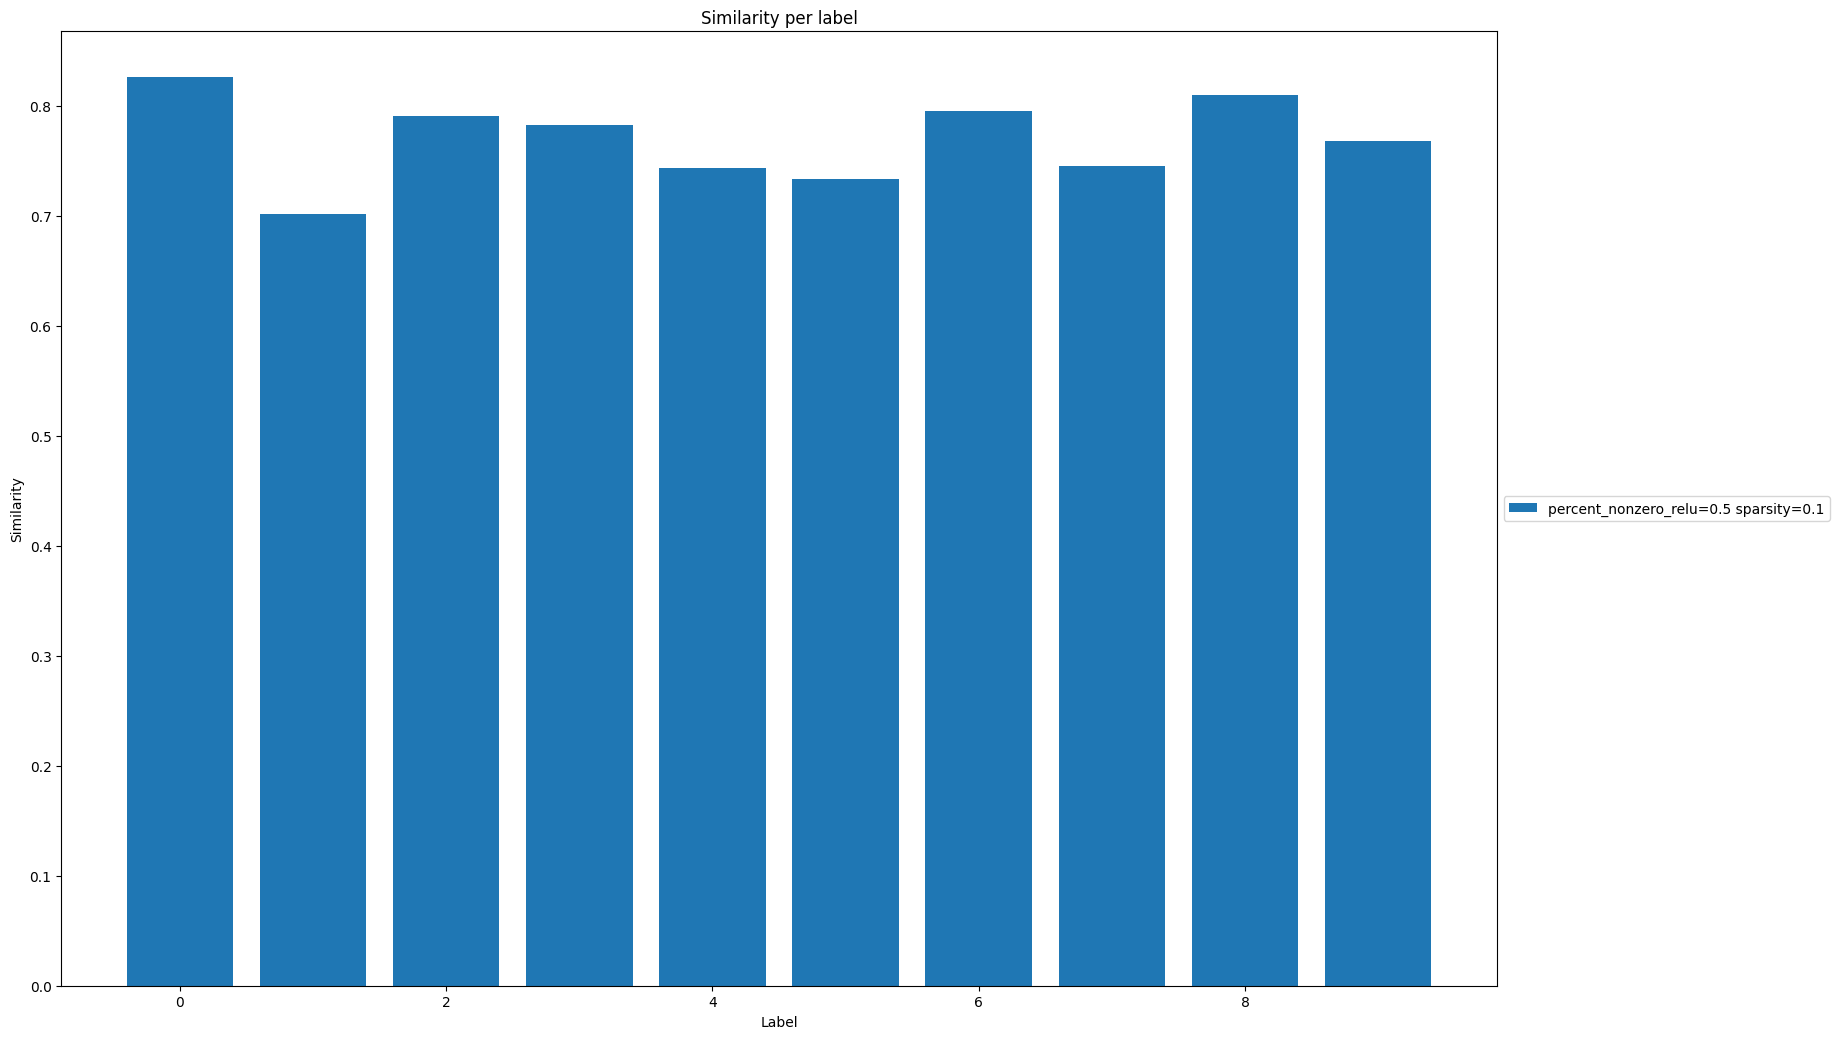

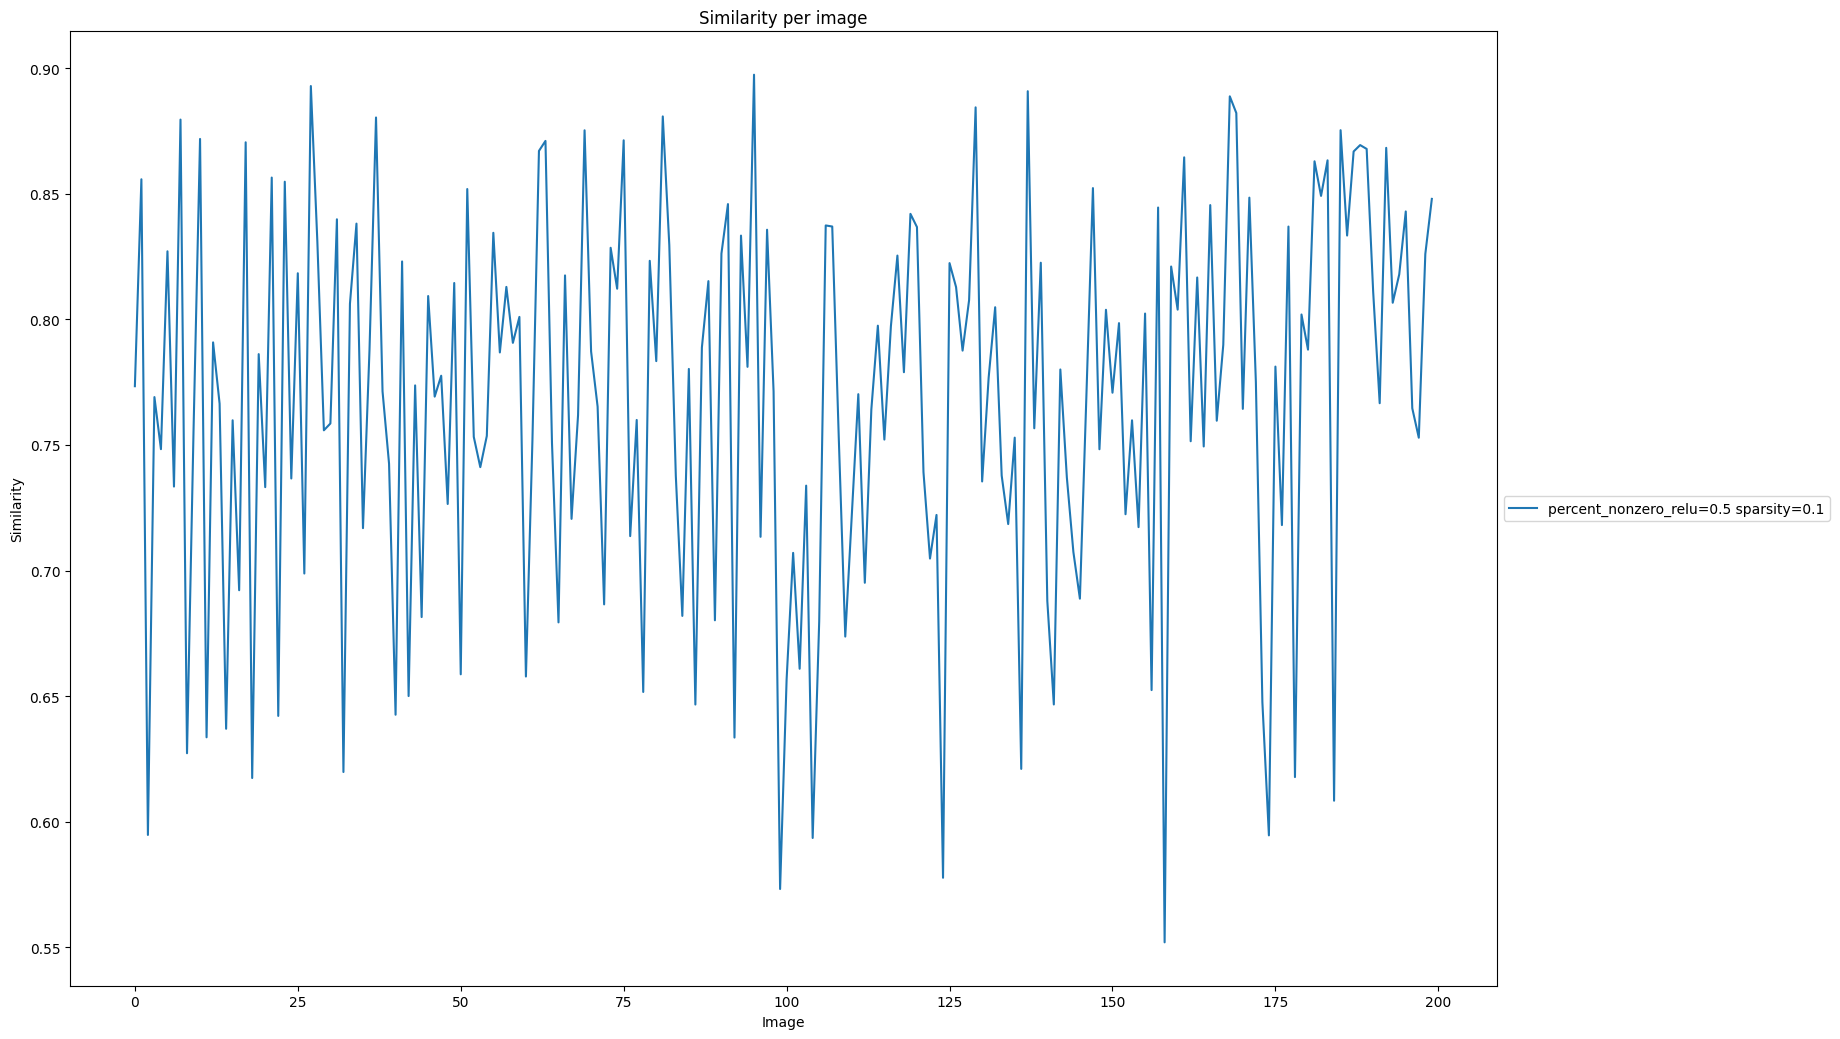

In [2]:
from vectorhash_functions import spacefillingcurve
from data_utils import prepare_data, load_mnist_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np

dataset = load_mnist_dataset()
data, noisy_data = prepare_data(
    dataset,
    num_imgs=num_imgs,
    preprocess_sensory=False,
    noise_level="none",
    across_dataset=True,
)

# REMOVE THESE LINES
# data = data.float() / 255.0
# noisy_data = noisy_data.float() / 255.0

# data, noisy_data = prepare_data_random(noise_scale=0)
v = spacefillingcurve(shapes)

g_positions, g_positions2, g_points, g_points_2 = GS.learn_path(
    observations=data, velocities=v[: len(data)]
)
recalled_imgs = GS.recall(noisy_data)
similarity = torch.cosine_similarity(data, recalled_imgs, dim=1)
mse = torch.nn.functional.mse_loss(data, recalled_imgs, reduction="none")
print(mse.mean())
print(similarity.mean())
for i in range(min(num_imgs, 5)):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    im1 = ax[0].imshow(data[(-i)].reshape(28, 28), cmap="gray")
    ax[0].set_title("Original")
    im2 = ax[1].imshow((recalled_imgs[(-i)]).reshape(28, 28), cmap="gray")
    title = f"Recalled similarity: {similarity[(-i)].item()}"
    ax[1].set_title(title)

    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    plt.show()


# BARCHART

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18.5, 10.5, forward=True)
# put legend outside of the plot
labels = dataset.train_labels[:num_imgs]
unique_labels = np.unique(labels)
similarity_per_label = []
for label in unique_labels:
    idx = labels == label
    similarity_per_label.append(similarity[idx].mean())
# make bars not overlap
label = f"percent_nonzero_relu={percent_nonzero_relu} sparsity={sparse_initialization}"
ax.bar(unique_labels, similarity_per_label, label=label)
ax.set_title("Similarity per label")
ax.set_xlabel("Label")
ax.set_ylabel("Similarity")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

fig.tight_layout()
plt.show()

# LINEPLOT
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18.5, 10.5, forward=True)

label = f"percent_nonzero_relu={percent_nonzero_relu} sparsity={sparse_initialization}"
ax.plot(similarity, label=label)
ax.set_title("Similarity per image")
ax.set_xlabel("Image")
ax.set_ylabel("Similarity")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

tensor(32.3349)


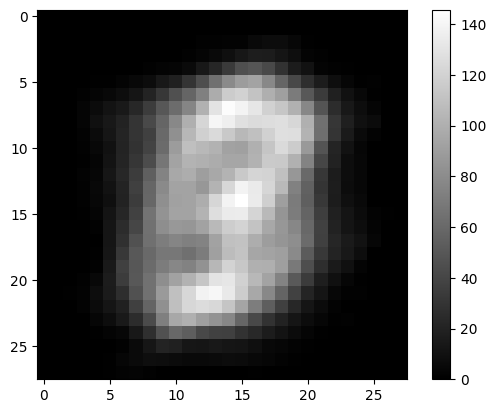

In [3]:
plt.imshow(data.mean(dim=0).reshape(28, 28), cmap="gray")
plt.colorbar()
print(data.mean())

In [4]:
from vectorhash_functions import *

mod_n_positions = []
mod_n_positions_2 = []
mod_n_states = []
mod_n_states_2 = []

# assume shapes are squares

for _ in lambdas:
    mod_n_positions.append(list())
    mod_n_positions_2.append(list())
    mod_n_states.append(list())
    mod_n_states_2.append(list())

for g in g_positions:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_positions[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

for g in g_positions2:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_positions_2[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

for g in g_points:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_states[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

for g in g_points_2:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_states_2[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

200
199
200
199


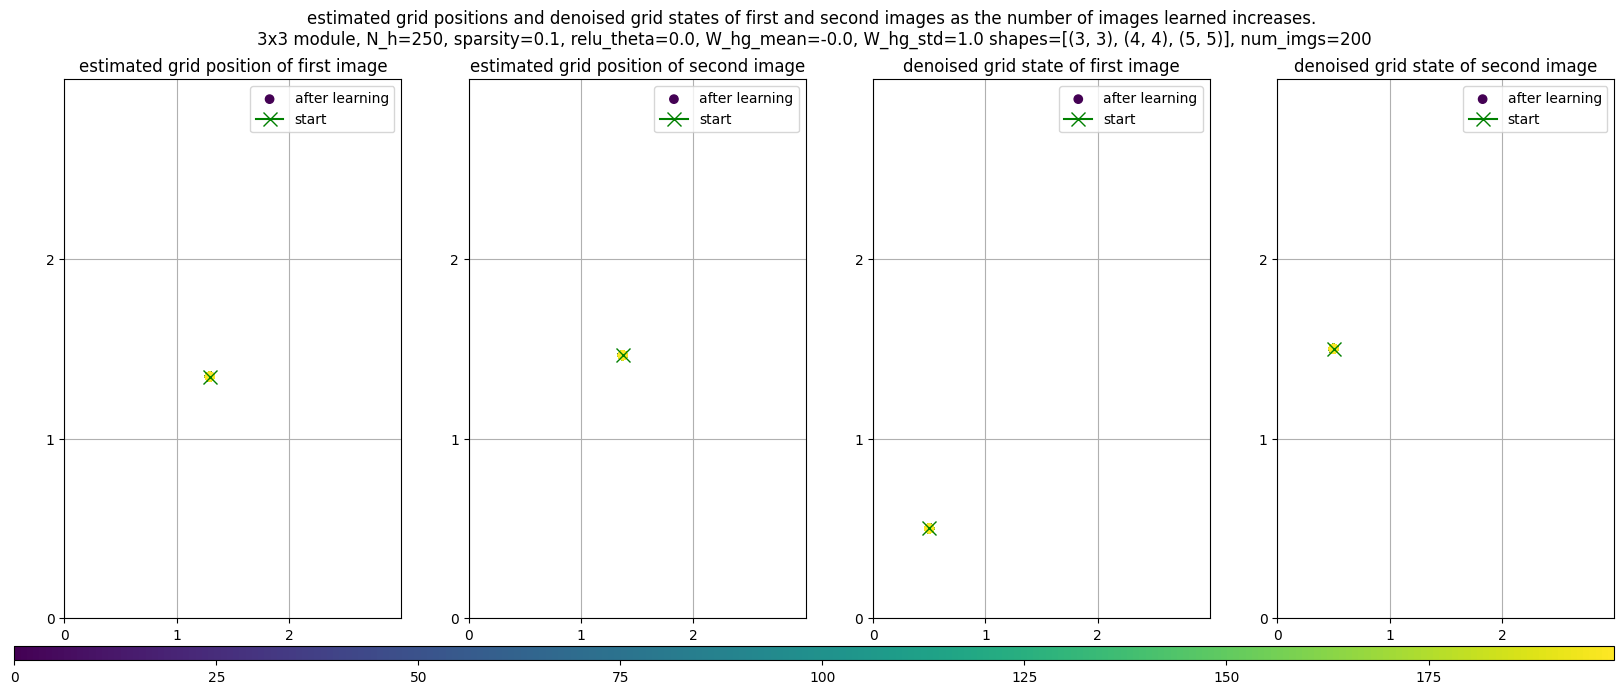

200
199
200
199


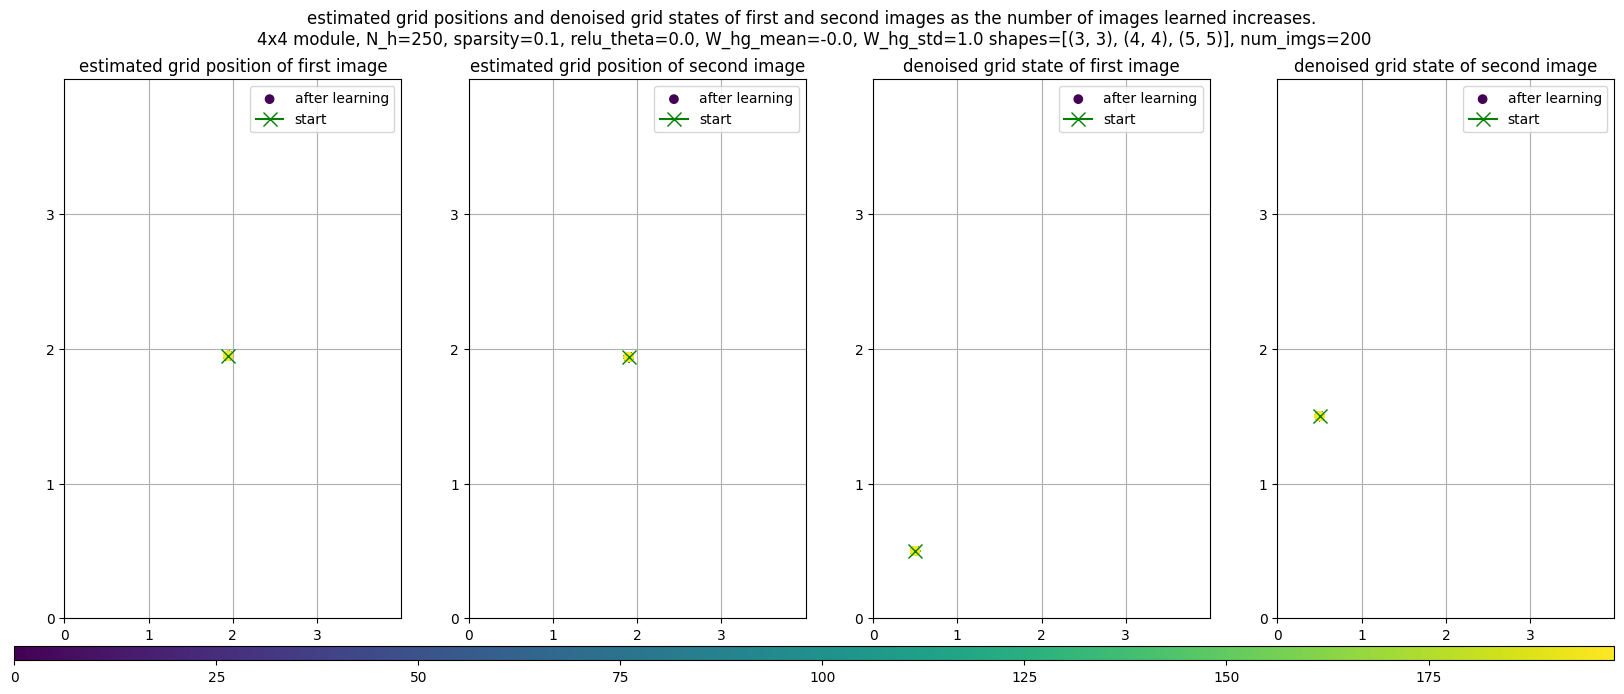

200
199
200
199


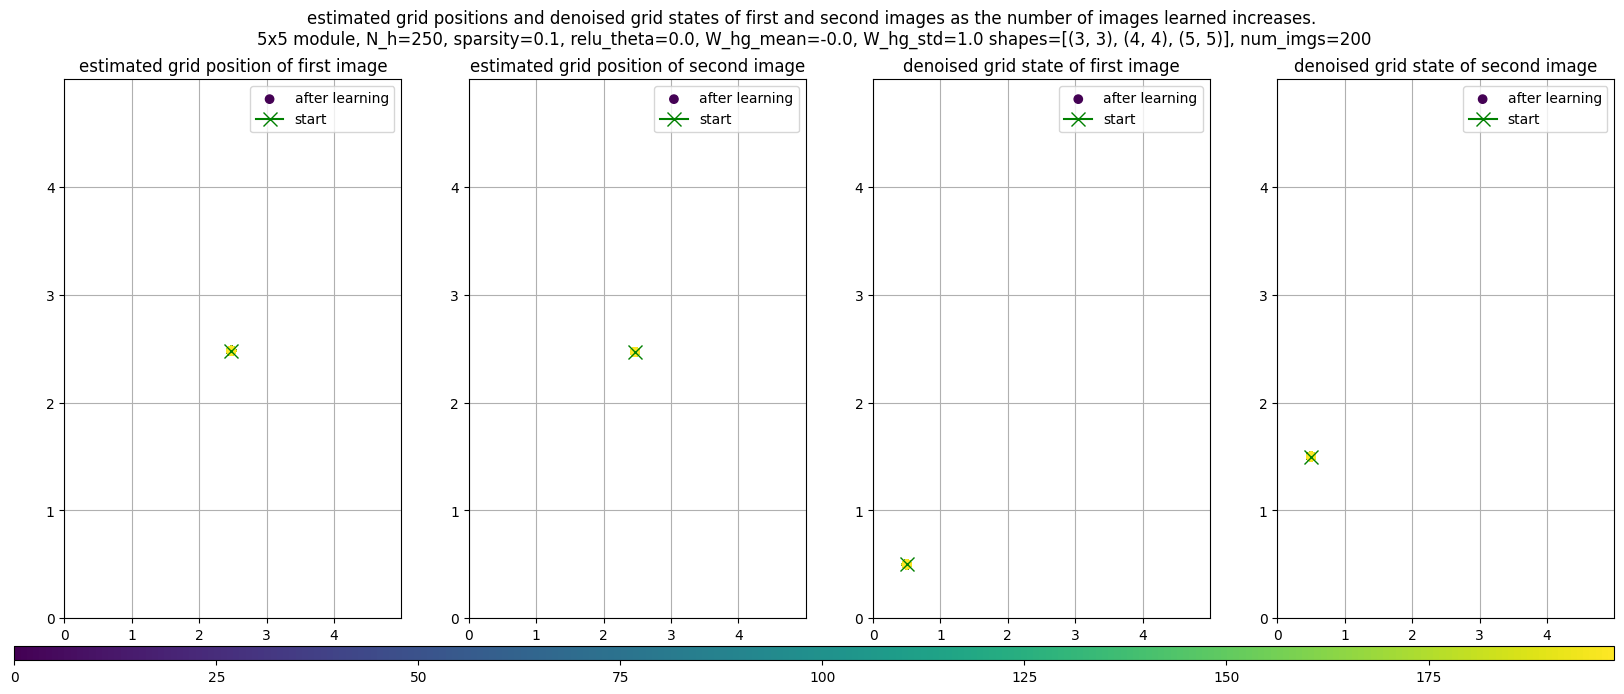

In [5]:
for i, l in enumerate(lambdas):
    GraphGrids(
        shapes_lists=[(l, l), (l, l), (l, l), (l, l)],
        points_lists=[
            mod_n_positions[i],
            mod_n_positions_2[i],
            mod_n_states[i],
            mod_n_states_2[i],
        ],
        first_points=[
            mod_n_positions[i][0],
            mod_n_positions_2[i][0],
            mod_n_states[i][0],
            mod_n_states_2[i][0],
        ],
        titles=[
            f"estimated grid position of first image",
            f"estimated grid position of second image",
            f"denoised grid state of first image",
            f"denoised grid state of second image",
        ],
        main_title=f"estimated grid positions and denoised grid states of first and second images as the number of images learned increases. \n{l}x{l} module, N_h={GS.N_h}, sparsity={round(sparse_initialization, 2)}, relu_theta={round(relu_theta, 2)}, W_hg_mean={round(W_hg_mean, 2)}, W_hg_std={W_hg_std} shapes={shapes}, num_imgs={num_imgs}",
    )

In [6]:
from vectorhash_functions import spacefillingcurve
from data_utils import prepare_data, load_mnist_dataset
import torch
from graph_utils import print_imgs_side_by_side_on_top

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
)

dataset = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

num_imgs = 201
data, noisy_data = prepare_data(
    dataset,
    num_imgs=num_imgs,
    preprocess_sensory=True,
    noise_level="none",
    use_fix=True,
)
LAST_N_IMGS = 10
# data, noisy_data = prepare_data_random(noise_scale=0) 
params = [0.01, 0.001, 0.0001, 0.01, 0.1, 1]
sims = []
fixed = []
v = spacefillingcurve(shapes)

lambdas = [3, 4, 5]
shapes = [(i, i) for i in lambdas]
for i in params:
    percent_nonzero_relu = 0.02
    W_gh_var = 1
    sparse_initialization = 0.8
    T = i
    W_hg_std = math.sqrt(W_gh_var)
    W_hg_mean = -W_hg_std * norm.ppf(1 - percent_nonzero_relu) / math.sqrt(len(lambdas))
    h_normal_mean = len(lambdas) * W_hg_mean
    h_normal_std = math.sqrt(len(lambdas)) * W_hg_std
    relu_theta = math.sqrt((1 - sparse_initialization) * len(lambdas)) * norm.ppf(
        1 - percent_nonzero_relu
    )

    print(
        percent_nonzero_relu,
        W_hg_mean,
        W_hg_std,
        h_normal_mean,
        h_normal_std,
        relu_theta,
    )

    GS = GridScaffold(
        shapes=shapes,
        N_h=1700,
        input_size=784,
        h_normal_mean=h_normal_mean,
        h_normal_std=h_normal_std,
        device=None,
        sparse_matrix_initializer=SparseMatrixBySparsityInitializer(
            sparsity=sparse_initialization, device="cpu"
        ),
        relu_theta=relu_theta,  ######
        from_checkpoint=False,
        T=T,
        ratshift=False,
        pseudo_inverse=False,
        batch_update=False,
        use_h_fix=False,
        learned_pseudo=False,
        epsilon=0.01,
        calculate_update_scaling_method="norm",
        MagicMath=False,
        sanity_check=False,
        calculate_g_method="fast",
        scaling_updates=True,
        dream_fix=10,
        ZeroTol=1,
        slumber=False,
    )
    g_positions, g_positions2, g_points, g_points_2, imgs_fixed = GS.learn_path(observations=data, velocities=v[: len(data)])
    recalled_imgs = GS.recall(noisy_data)
    similarity = torch.cosine_similarity(data, recalled_imgs, dim=1)
    sims.append(similarity)
    human_render = []
    for o in range(LAST_N_IMGS):
        a = []
        a.append(data[-(o+1)].reshape(28, 28))
        a.append(recalled_imgs[-(o+1)].reshape(28, 28))
        human_render.append(a)
    fixed.append(imgs_fixed)

    imgname = "images_graphs/TEMP_CHECK" + str(params.index(i)) + ".png"
    print_imgs_side_by_side_on_top(human_render, out=imgname, captions=["Original", "Recalled"], title="TEMP " + str(i))

        fig.colorbar(im1, ax=ax[0])
        fig.colorbar(im2, ax=ax[1])
        plt.show()


# BARCHART

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18.5, 10.5, forward=True)
# put legend outside of the plot
for i in range(len(sims)):
    similarity = sims[i]
    percent_nonzero_relu, sparse_initialization = params[i]

    labels = dataset.train_labels[:len(data)]
    unique_labels = np.unique(labels)
    similarity_per_label = []
    for label in unique_labels:
        idx = labels == label
        similarity_per_label.append(similarity[idx].mean())
    # make bars not overlap
    ax.bar(unique_labels, similarity_per_label, label="TEMP " + str(params[i]))
    ax.set_title("Similarity per label")
    ax.set_xlabel("Label")
    ax.set_ylabel("Similarity")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.savefig("images_graphs/SLUMBER_LABELS.png")
plt.close(fig)

# LINEPLOT
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18.5, 10.5, forward=True)
for i in range(len(sims)):
    similarity = sims[i]
    percent_nonzero_relu, sparse_initialization = params[i]
    label = (
        f"percent_nonzero_relu={percent_nonzero_relu} sparsity={sparse_initialization}"
    )
    ax.plot(similarity, label=label)
    ax.set_title("Similarity per image")
    ax.set_xlabel("Image")
    ax.set_ylabel("Similarity")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.savefig("images_graphs/SLUMBER_SIMS.png")
plt.close(fig)

# LINEPLOT number of images fixed every 10 images
for i in range(len(fixed)):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(18.5, 10.5, forward=True)
    ax.plot(fixed[i], label="TEMP " + str(params[i]))
    ax.set_title("Number of images fixed")
    ax.set_xlabel("DREAM SEQUENCE NUMBER")
    ax.set_ylabel("Fixed")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    
plt.savefig("images_graphs/SLUMBER_FIXED" + str(params[i]) + ".png")
plt.close(fig)





TypeError: prepare_data() got an unexpected keyword argument 'use_fix'

200
200


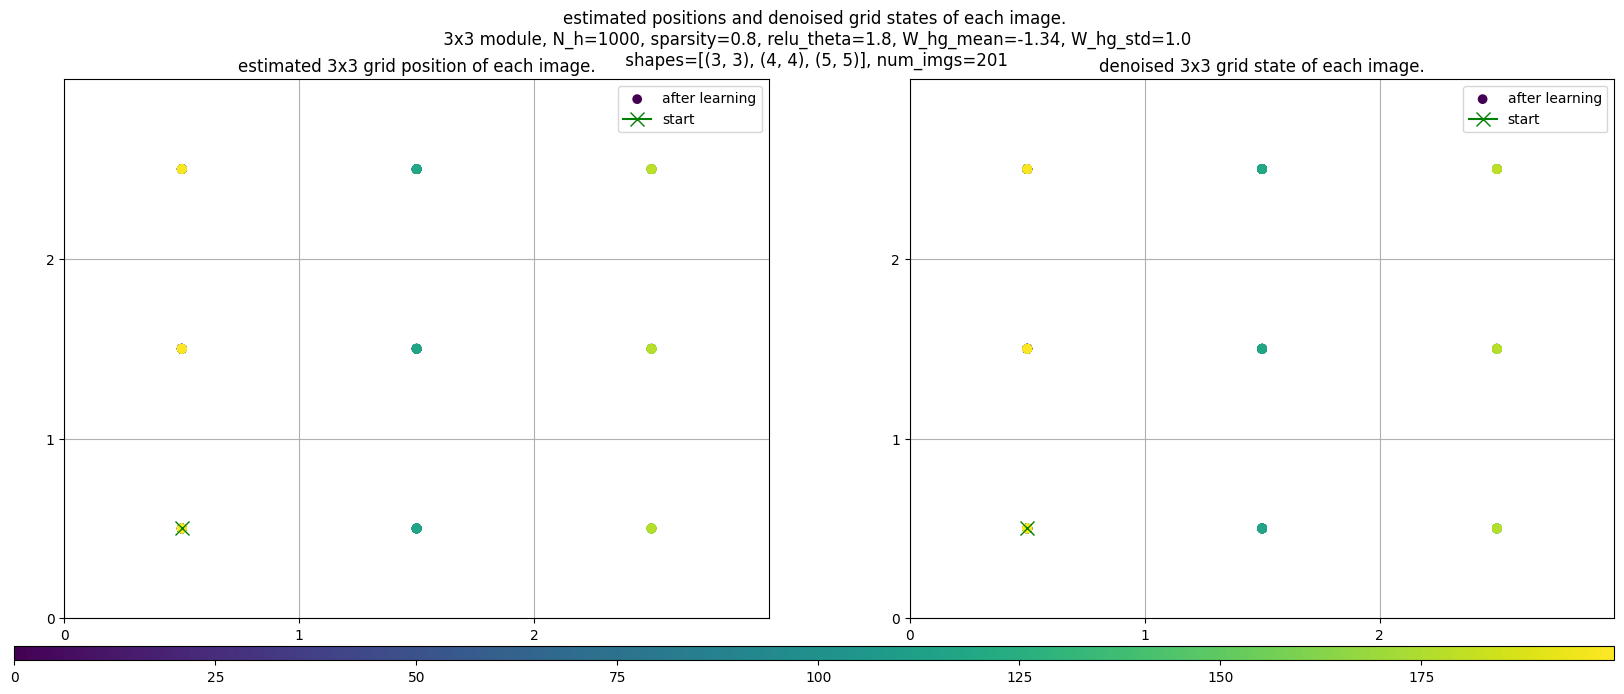

200
200


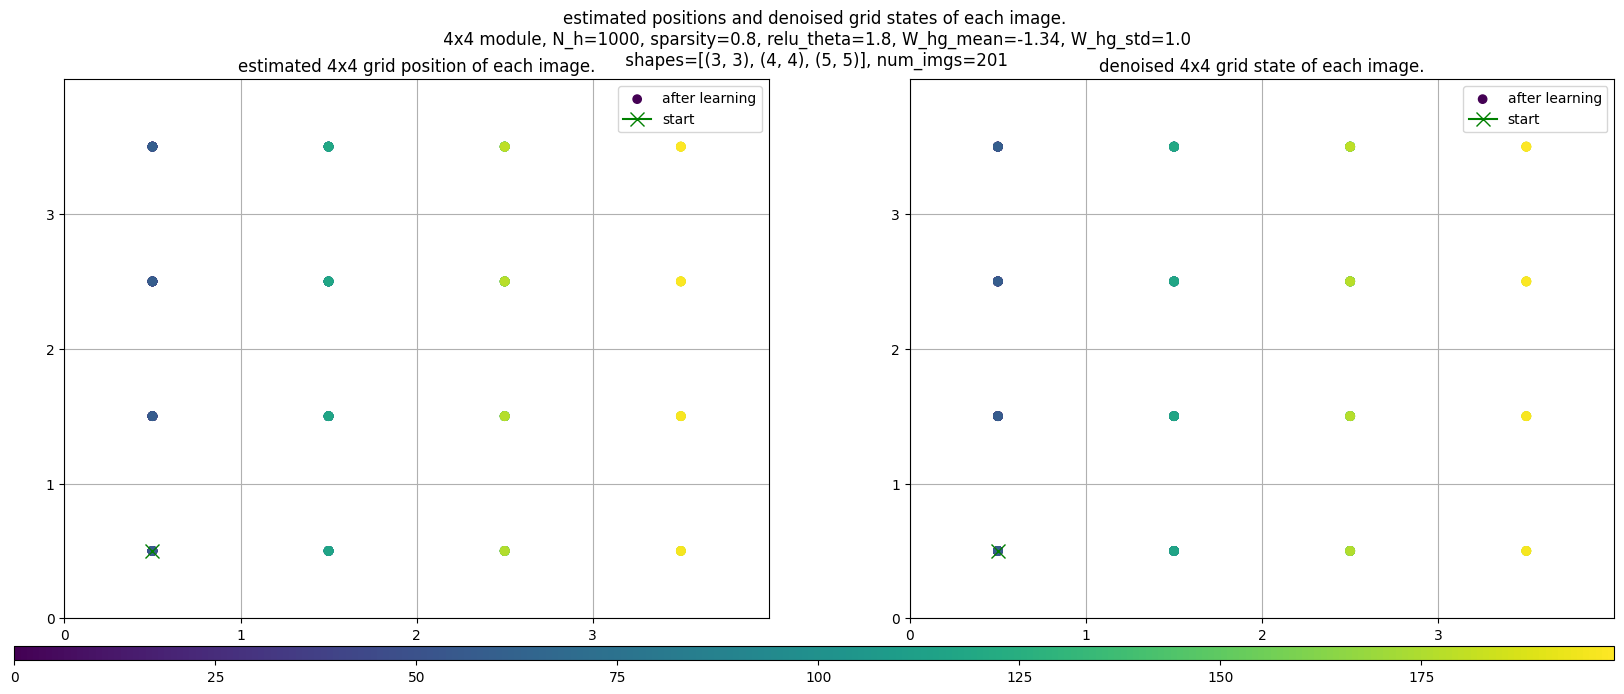

200
200


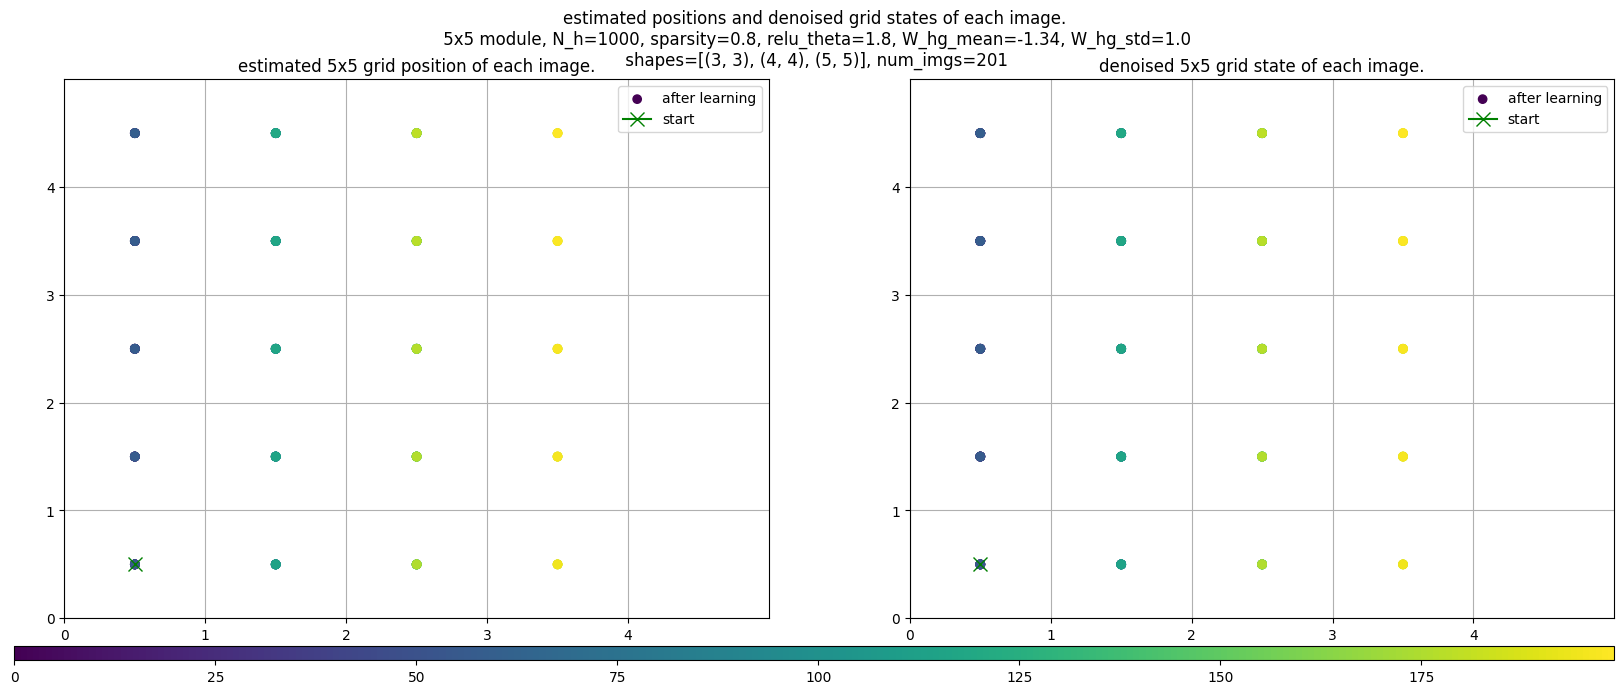

In [ ]:
point_positions_n = []
point_states_n = []
for l in lambdas:
    point_positions_n.append([])
    point_states_n.append([])

for img in data:
    pos = GS.estimate_position(img)
    state = GS.denoise(
        GS.grid_from_hippocampal(GS.hippocampal_from_sensory(img))
    ).flatten()

    p = 0
    for i, l in enumerate(lambdas):
        point_positions_n[i].append(ConvertToXYNew(pos[p : p + l**2], (l, l)))
        point_states_n[i].append(ConvertToXYNew(state[p : p + l**2], (l, l)))
        p += l**2

for i, l in enumerate(lambdas):
    GraphGrids(
        shapes_lists=[(l, l), (l, l)],
        points_lists=[point_positions_n[i], point_states_n[i]],
        first_points=[point_positions_n[i][0], point_states_n[i][0]],
        titles=[
            f"estimated {l}x{l} grid position of each image.",
            f"denoised {l}x{l} grid state of each image.",
        ],
        main_title=f"estimated positions and denoised grid states of each image.\n {l}x{l} module, N_h={GS.N_h}, sparsity={round(sparse_initialization, 2)}, relu_theta={round(relu_theta,2 )}, W_hg_mean={round(W_hg_mean, 2)}, W_hg_std={W_hg_std}\n shapes={shapes}, num_imgs={num_imgs}",
    )

Unique Hs seen while recalling: 1
Unique Gs seen while recalling (before denoising): 1
Unique Gs seen while recalling (after denoising): 1
Unique Hs seen while recalling (after denoising): 1
avg nonzero H: 418.0
avg nonzero H_denoised: 224.0
tensor(0.4504)
tensor(3.7709e-08)


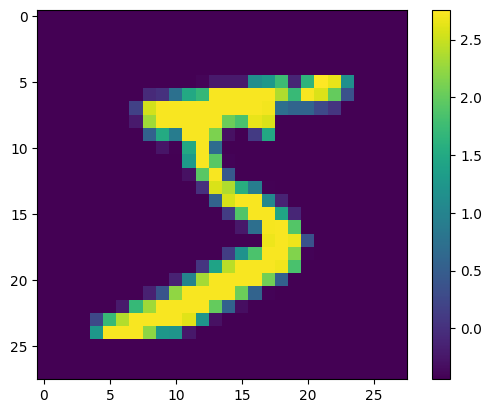

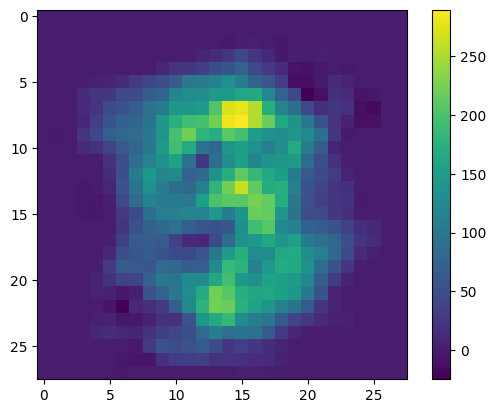

In [11]:
img = data[0]
recalled = GS.recall(img)
print(torch.cosine_similarity(img, recalled).mean())

plt.imshow(img.reshape(28, 28))
print(img.mean())
plt.colorbar()
plt.show()
plt.imshow((recalled).reshape(28, 28))
plt.colorbar()
plt.show()

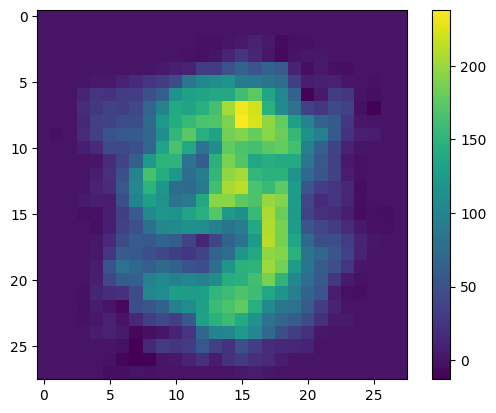

In [12]:
plt.imshow(
    GS.sensory_from_hippocampal(GS.hippocampal_from_grid(GS.G[3200])).reshape(28, 28)
)
plt.colorbar()
plt.show()

/var/folders/by/wwwbwc016yxfhlbgfph7_xmc0000gn/T/ipykernel_32044/728696423.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_by_class = torch.tensor(data).float().to("cpu")


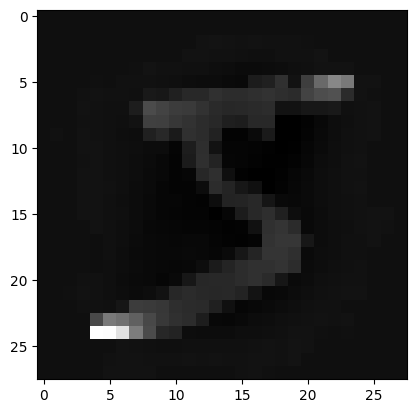

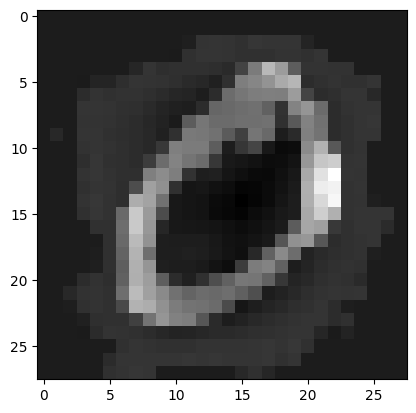

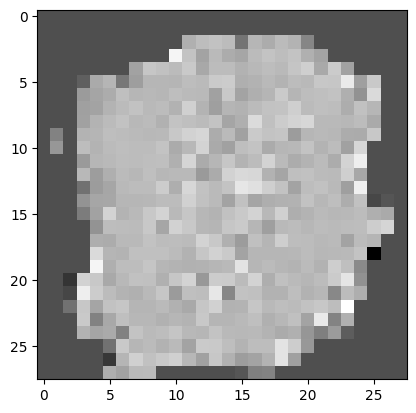

200
200


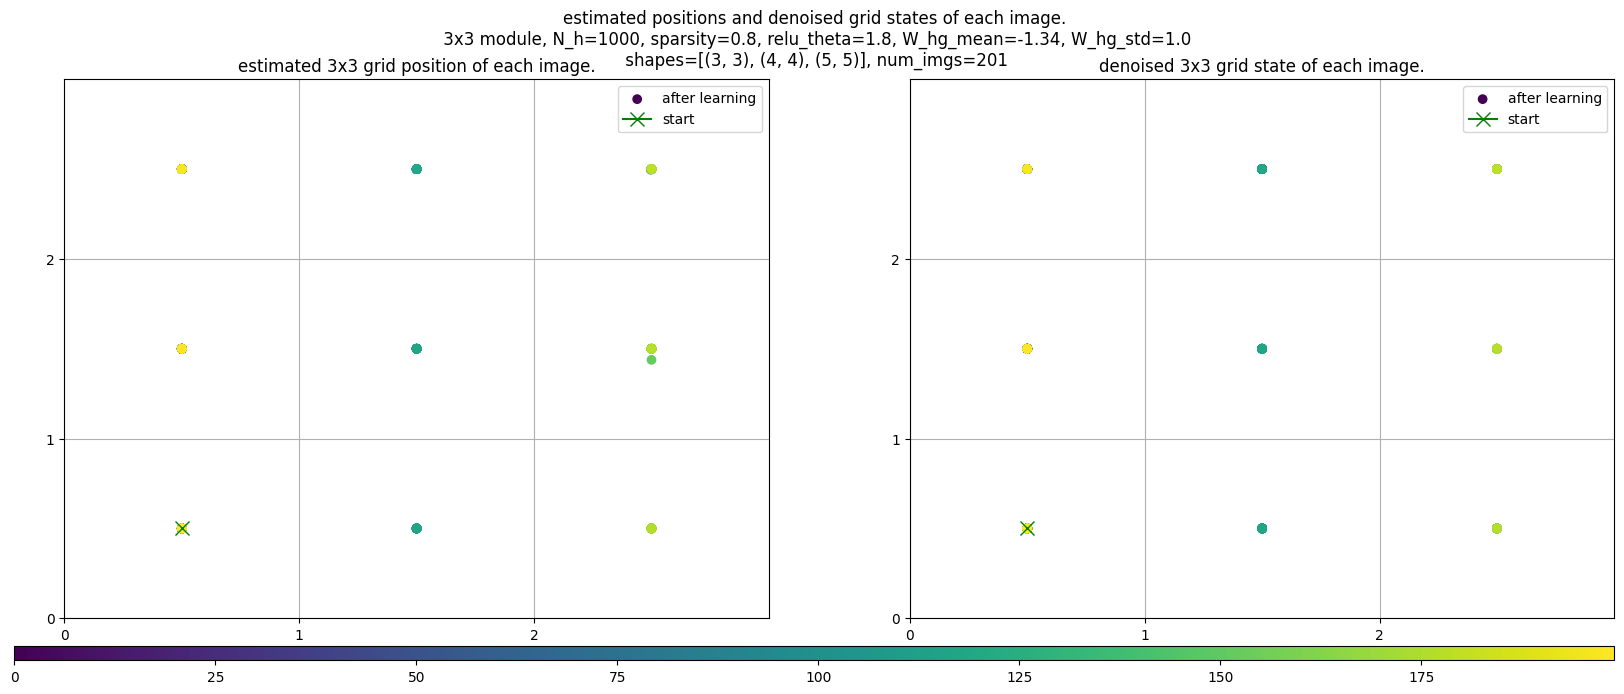

200
200


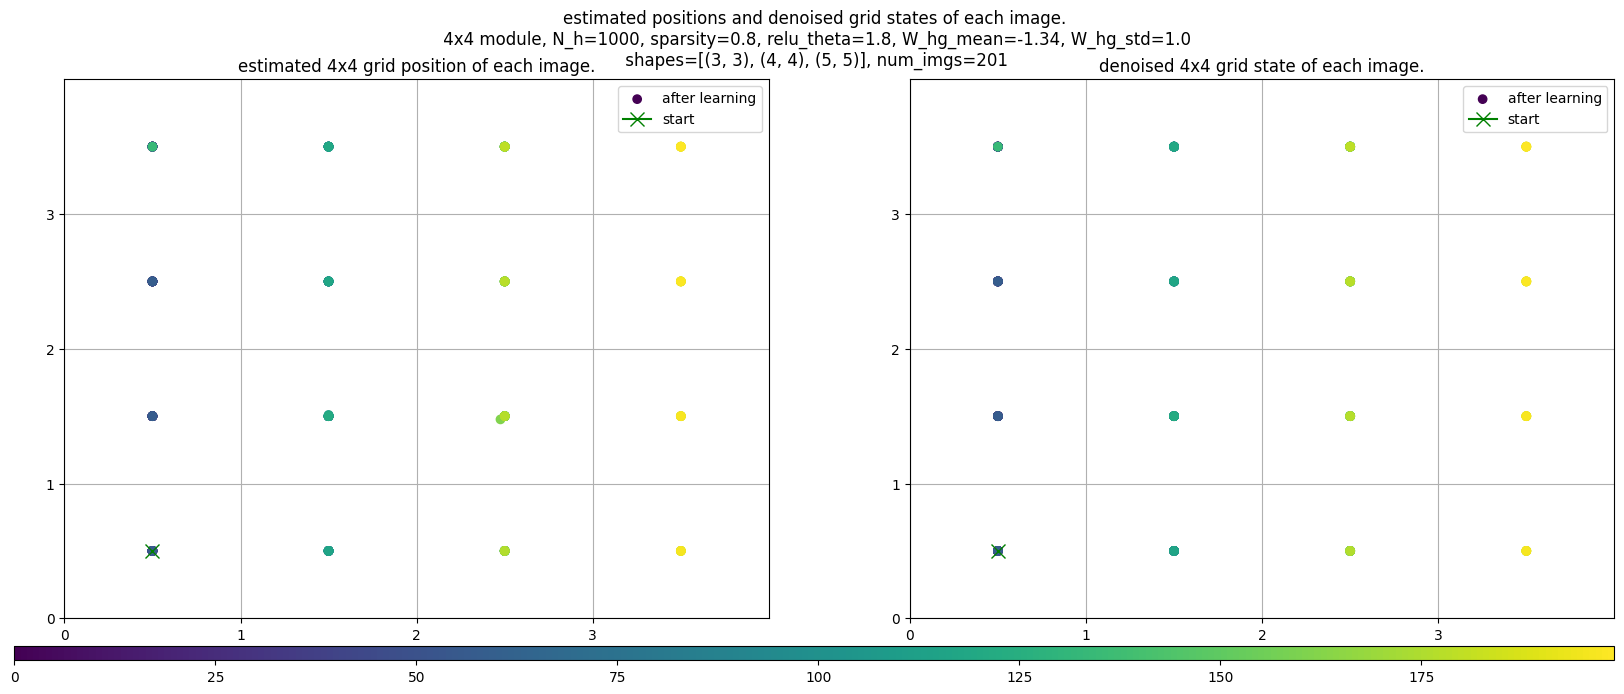

200
200


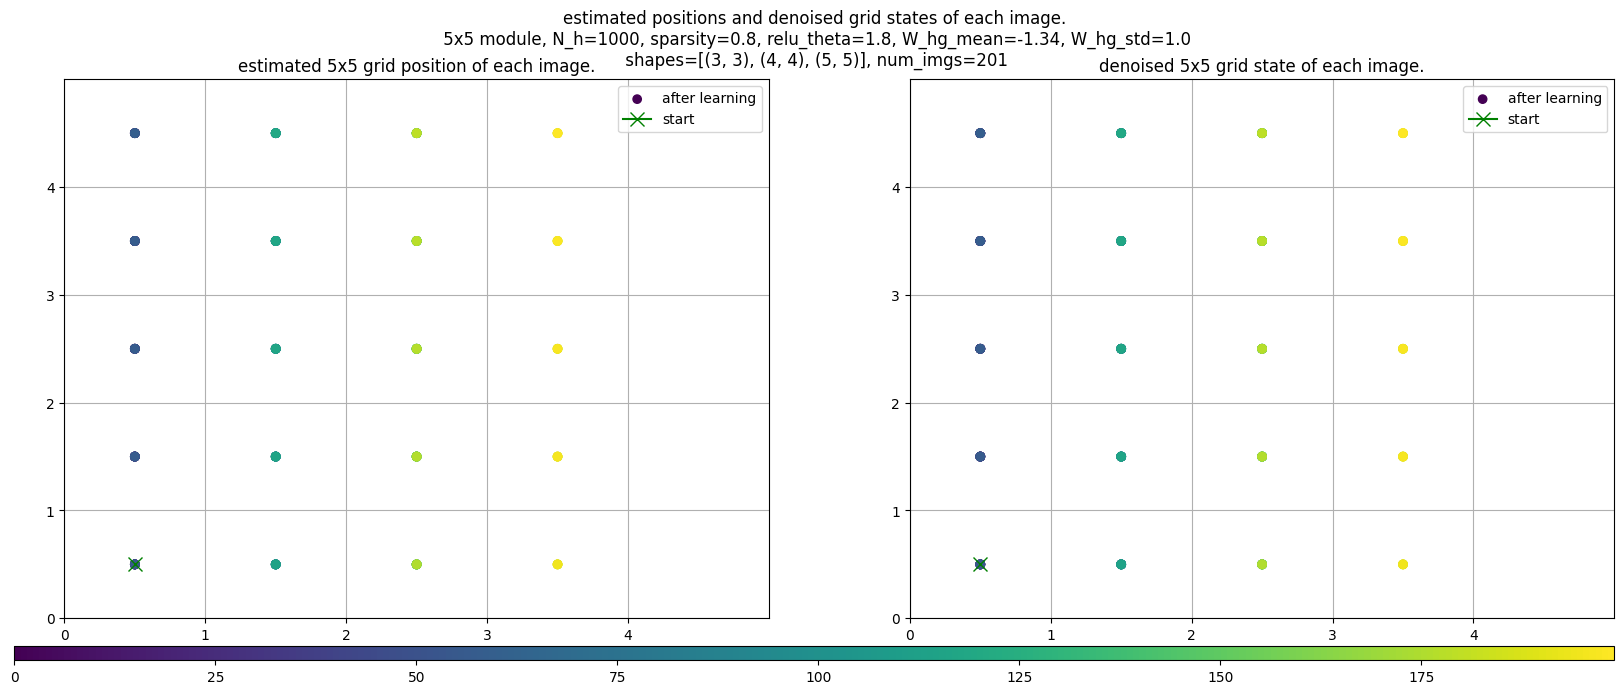

In [13]:
zero_indices = (dataset.train_labels == 0).nonzero().flatten()

data_by_class = dataset.data[zero_indices][:200].reshape(200, 784)
data_by_class = torch.tensor(data).float().to("cpu")
data_by_class = (data - data.mean(dim=0)) / (data.std(dim=0) + 1e-8)

plt.imshow(data_by_class[0].reshape(28, 28), cmap="gray")
plt.show()
plt.imshow(data_by_class[1].reshape(28, 28), cmap="gray")
plt.show()
plt.imshow(data_by_class.mean(dim=0).reshape(28, 28), cmap="gray")
plt.show()

point_positions_n = []
point_states_n = []
for l in lambdas:
    point_positions_n.append([])
    point_states_n.append([])

for img in data_by_class:
    pos = GS.estimate_position(img)
    state = GS.denoise(
        GS.grid_from_hippocampal(GS.hippocampal_from_sensory(img))
    ).flatten()

    p = 0
    for i, l in enumerate(lambdas):
        point_positions_n[i].append(ConvertToXYNew(pos[p : p + l**2], (l, l)))
        point_states_n[i].append(ConvertToXYNew(state[p : p + l**2], (l, l)))
        p += l**2

for i, l in enumerate(lambdas):
    GraphGrids(
        shapes_lists=[(l, l), (l, l)],
        points_lists=[point_positions_n[i], point_states_n[i]],
        first_points=[point_positions_n[i][0], point_states_n[i][0]],
        titles=[
            f"estimated {l}x{l} grid position of each image.",
            f"denoised {l}x{l} grid state of each image.",
        ],
        main_title=f"estimated positions and denoised grid states of each image.\n {l}x{l} module, N_h={GS.N_h}, sparsity={round(sparse_initialization, 2)}, relu_theta={round(relu_theta,2 )}, W_hg_mean={round(W_hg_mean, 2)}, W_hg_std={W_hg_std}\n shapes={shapes}, num_imgs={num_imgs}",
    )